# Explainable AI and facial recognition

Our project focuses on explainable AI (XAI) and bias of the models. Explainability of a model can provide insights into its decisions, possible bias, and how to prevent them. Within this approach, we train a neural net on facial recognition, as facial recognition models are often prone to racial bias. With this project we will guide you through practical application of facial recognition models, and access their performance. Let's dove right in!

First, we import the necessary libraries

In [1]:
from src.EDA import FaceDatasetAnalyzer
from src import config
from src.bias_assessment import (
    load_classes, load_model, get_val_loader,
    evaluate_fairness, summarize_model
)
from src.plot_generator import plot_acc_prec_f1_metrics, plot_bias_fairness_metrics
import matplotlib.pyplot as plt
import numpy as np
import torch

import os
from math import ceil
from PIL import Image
import cv2

import tensorflow as tf
import torch.nn as nn
from torchvision import transforms
import torchvision.transforms as T

%matplotlib inline
%config InlineBackend.figure_format='retina'

import xplique
from xplique.wrappers import TorchWrapper
from xplique.plots import plot_attributions
import pandas as pd
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, Occlusion, Rise, GuidedBackprop, Lime, KernelShap, SobolAttributionMethod)
from xplique.metrics import MuFidelity, Deletion, Insertion, AverageStability

from captum.attr import Saliency
print("Torch version:", torch.__version__)



Torch version: 2.2.2


/Users/admin/miniconda3/envs/deepl_final_project_xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This next code snippet shows general descriptives about our dataset. The classes are balanced, which is importat to ensure that any difference in performance between classes is not due to the classes size

Classes detected:
  - asian_females
  - asian_males
  - black_females
  - black_males
  - indian_females
  - indian_males
  - white_females
  - white_males

Class distribution:
asian_females: 2500
asian_males: 2500
black_females: 2500
black_males: 2500
indian_females: 2500
indian_males: 2500
white_females: 2500
white_males: 2500

Sampled 500 images for dimension analysis.
Average width: 107.8
Average height: 123.9


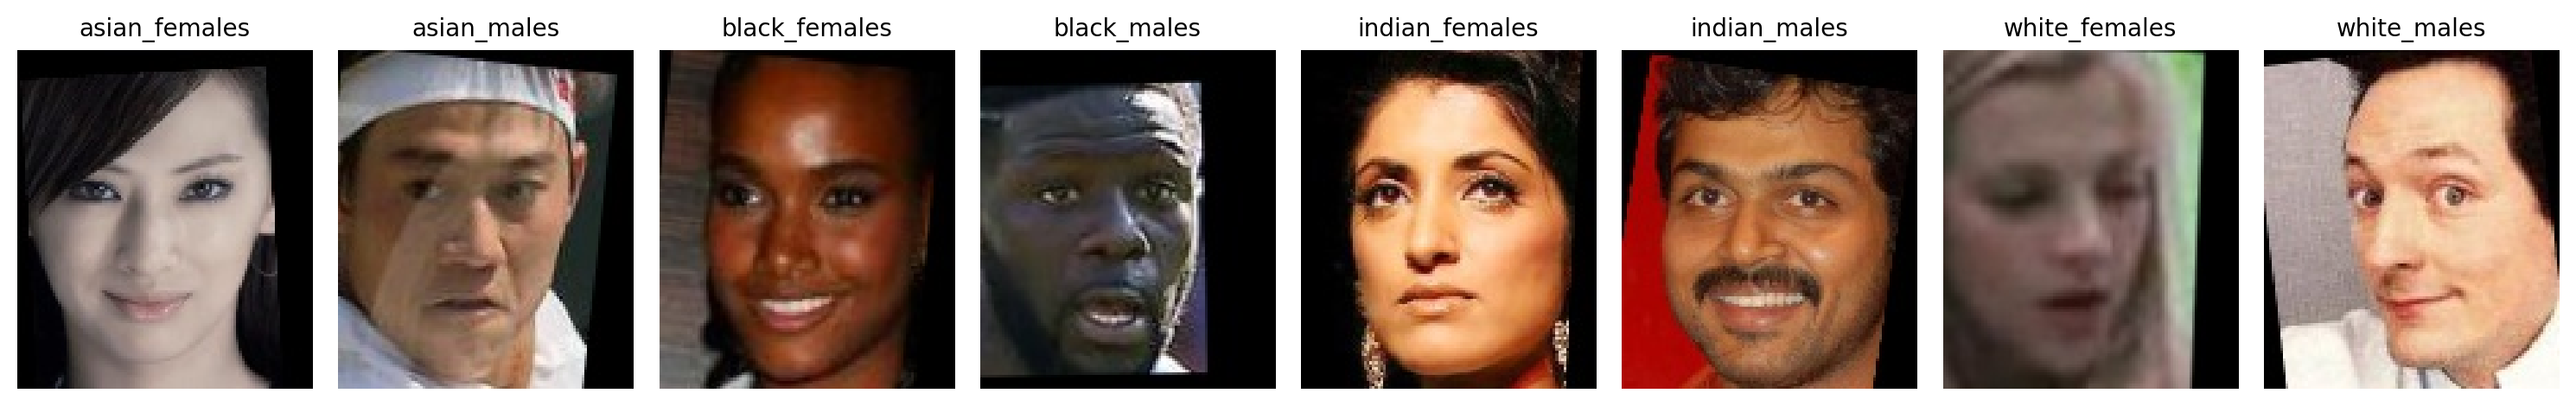

Computing mean faces: 100%|██████████| 8/8 [00:50<00:00,  6.31s/it]


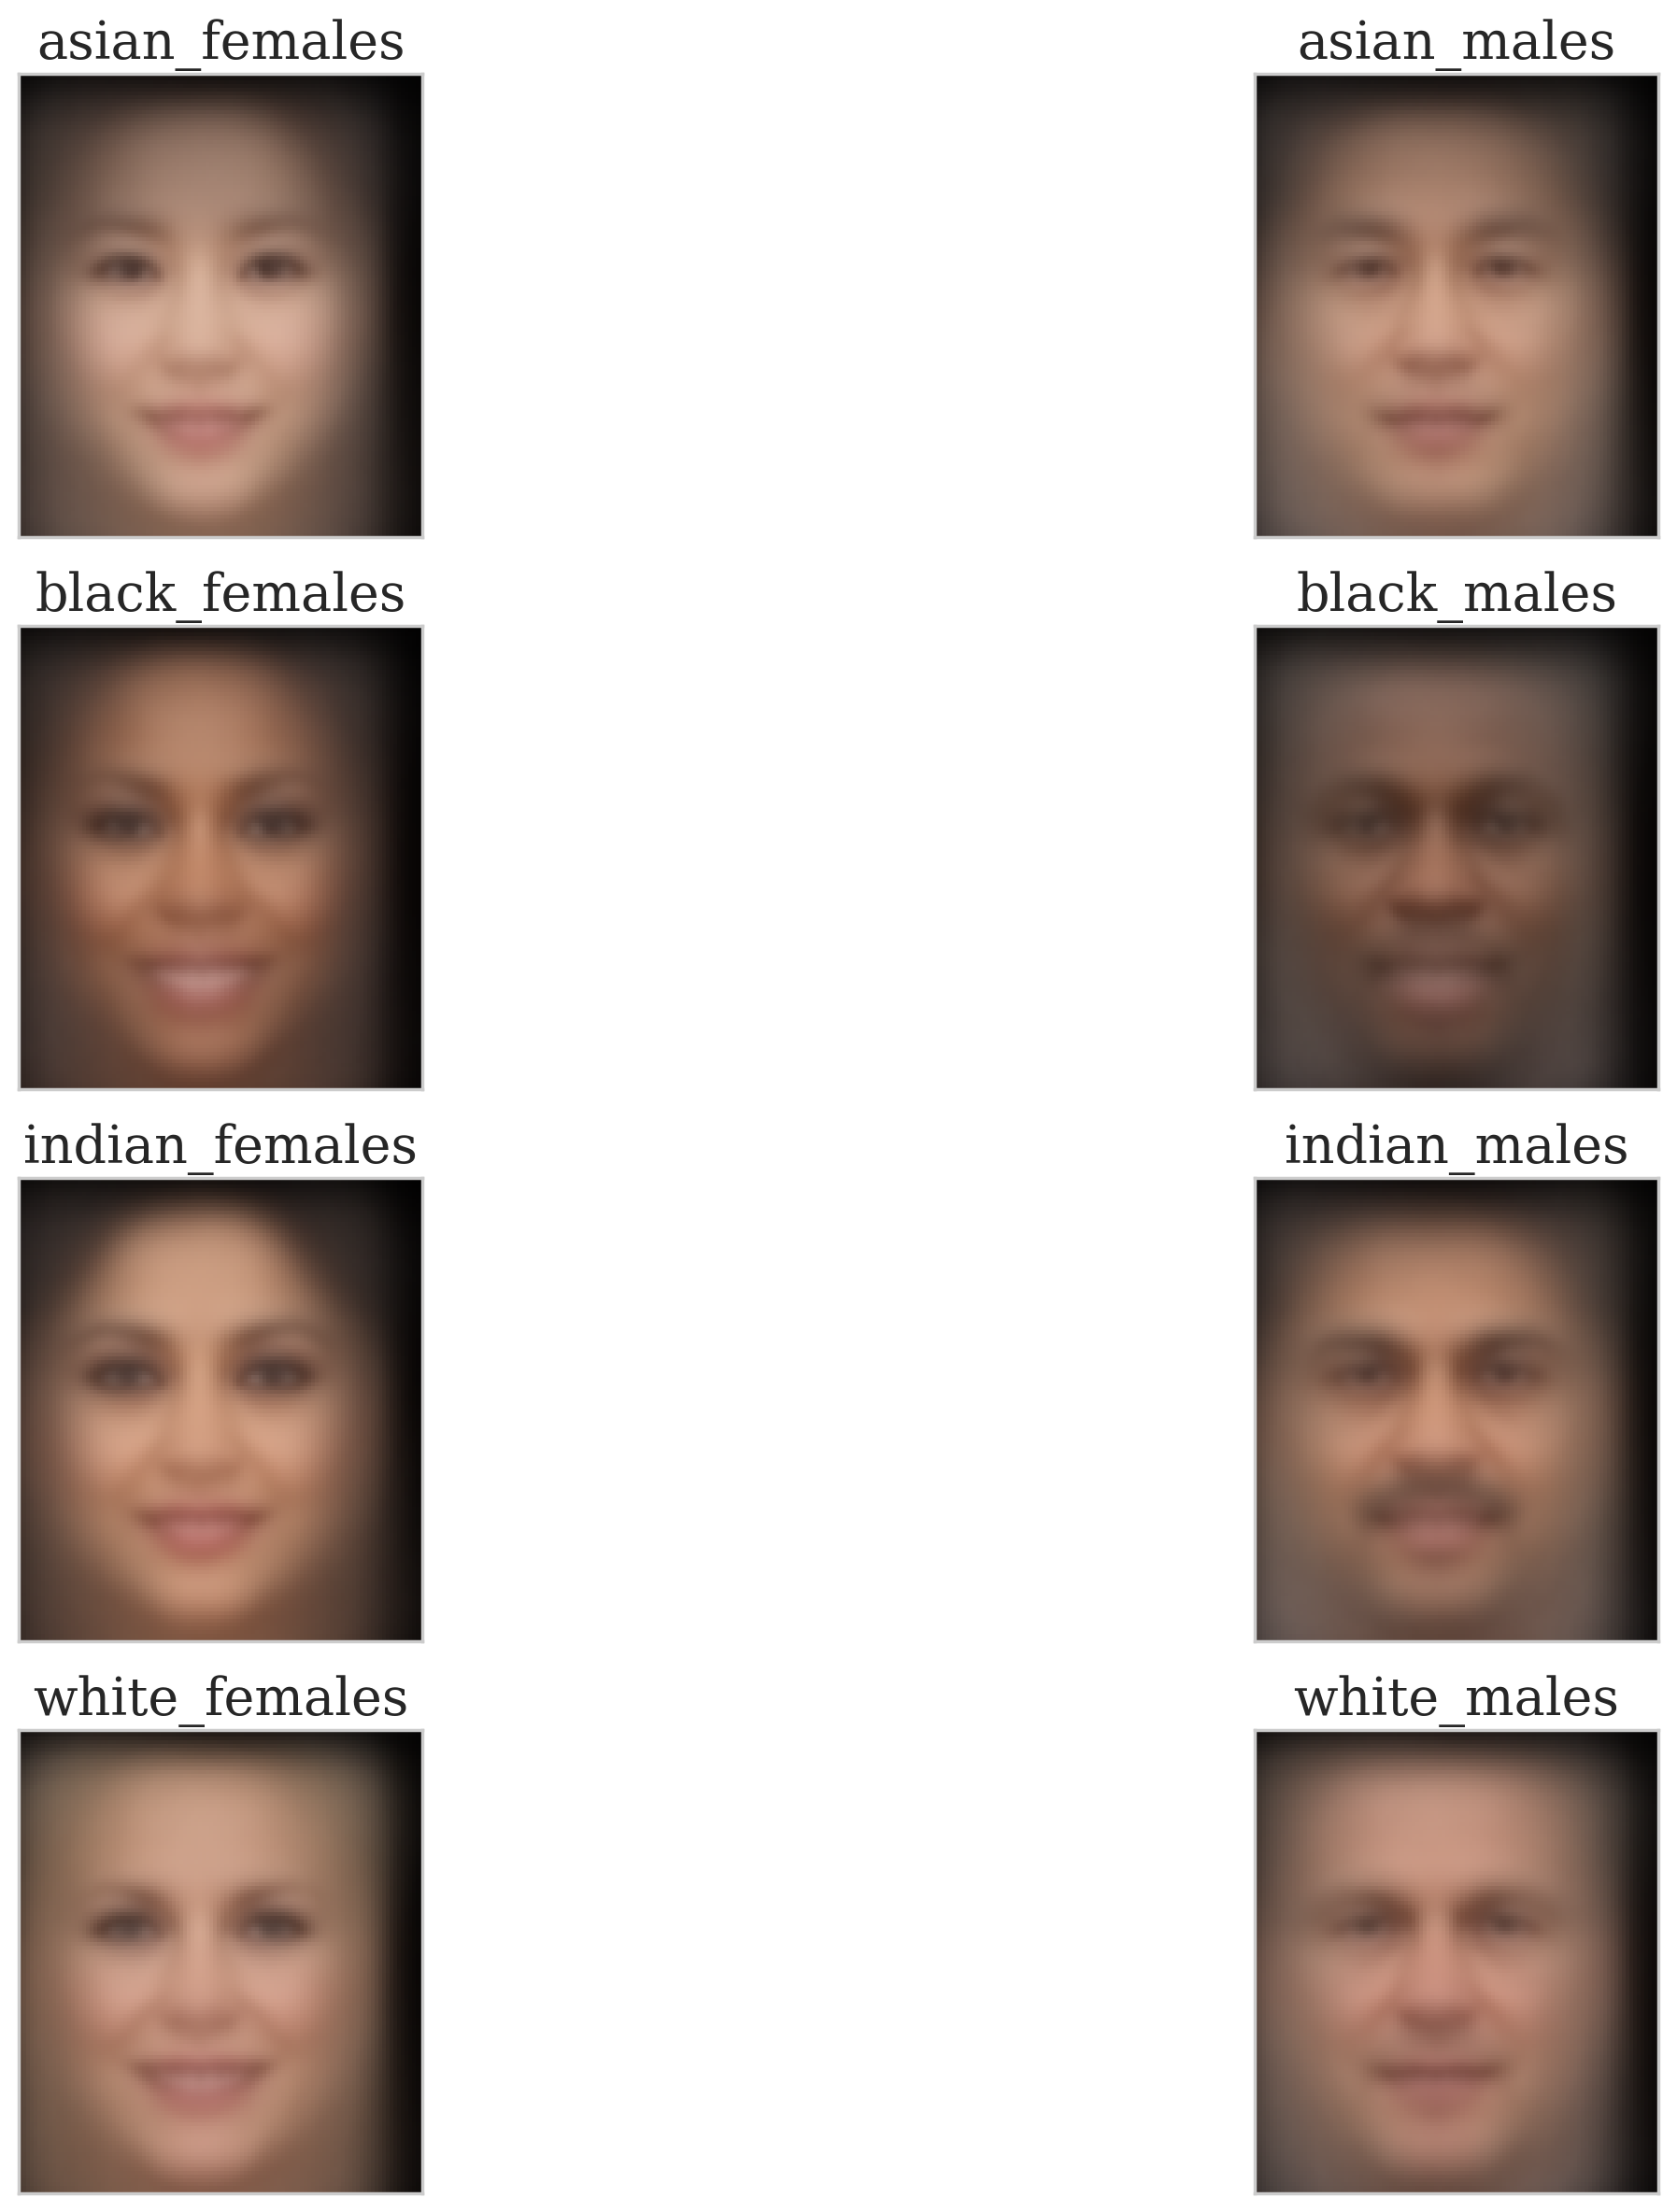

[array([[[0.04206285, 0.03658871, 0.03596776],
         [0.04382888, 0.03834427, 0.03724685],
         [0.0468344 , 0.04033737, 0.03952517],
         ...,
         [0.01462954, 0.01248197, 0.01213546],
         [0.01379196, 0.01155095, 0.01143267],
         [0.01303278, 0.01080711, 0.01072101]],
 
        [[0.04714759, 0.04121226, 0.04050414],
         [0.04880097, 0.04315213, 0.04162359],
         [0.05314616, 0.0464583 , 0.04517463],
         ...,
         [0.01644234, 0.01424809, 0.01384312],
         [0.0153752 , 0.01310588, 0.01287811],
         [0.01427493, 0.01208172, 0.01183606]],
 
        [[0.05455689, 0.0478943 , 0.04659087],
         [0.05660858, 0.05015139, 0.04806414],
         [0.06194157, 0.05429403, 0.05249865],
         ...,
         [0.01822201, 0.01590893, 0.01540785],
         [0.0166165 , 0.01426758, 0.01393273],
         [0.01519999, 0.01293788, 0.01259581]],
 
        ...,
 
        [[0.22941933, 0.190037  , 0.17399758],
         [0.24454232, 0.20439775, 0.18679

In [2]:
results_DIR = config.DATA_DIR

# Or step-by-step
analyzer = FaceDatasetAnalyzer(results_DIR)
analyzer.print_classes()
analyzer.print_class_distribution()
analyzer.print_dimension_stats()
analyzer.plot_sample_images()
analyzer.plot_mean_faces()

In [3]:
classes = load_classes(results_DIR)

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model(len(classes), "./models/face_classifier_resnet18.pth", device)

# Summarize model
summarize_model(model)

# Load validation loader
val_loader, _ = get_val_loader(results_DIR, "val_indices.pt")

# Evaluate fairness
results = evaluate_fairness(model, val_loader, classes, device)

In [4]:
results

{'overall_accuracy': 81.575,
 'per_class_accuracy': {'asian_females': 86.04206500956023,
  'asian_males': 76.42276422764228,
  'black_females': 80.37974683544303,
  'black_males': 91.10671936758892,
  'indian_females': 80.63157894736842,
  'indian_males': 82.17821782178217,
  'white_females': 77.22007722007721,
  'white_males': 78.30374753451676},
 'accuracy_std_dev': 4.605573497860898,
 'precision': {'asian_females': 84.90566037735849,
  'asian_males': 75.0499001996008,
  'black_females': 77.91411042944786,
  'black_males': 82.32142857142857,
  'indian_females': 82.36559139784946,
  'indian_males': 81.85404339250493,
  'white_females': 88.30022075055187,
  'white_males': 80.2020202020202},
 'macro_precision': 81.61412191509527,
 'recall': {'asian_females': 86.04206500956023,
  'asian_males': 76.42276422764228,
  'black_females': 80.37974683544303,
  'black_males': 91.10671936758892,
  'indian_females': 80.63157894736842,
  'indian_males': 82.17821782178217,
  'white_females': 77.22007

## Fairness Evaluation 

First, we'll take a look at the common metrics to evaluate classification problems. How does precision, accuracy and f1 vary across groups? 

⚡ Some flash definitons as reminders!
- Precision: Measures how often the model is correct when it predicts a specific class.
- Accuracy: Measures how many images the model classified correctly out of all images.
- F1: Represents the model’s overall ability to recognize a class.


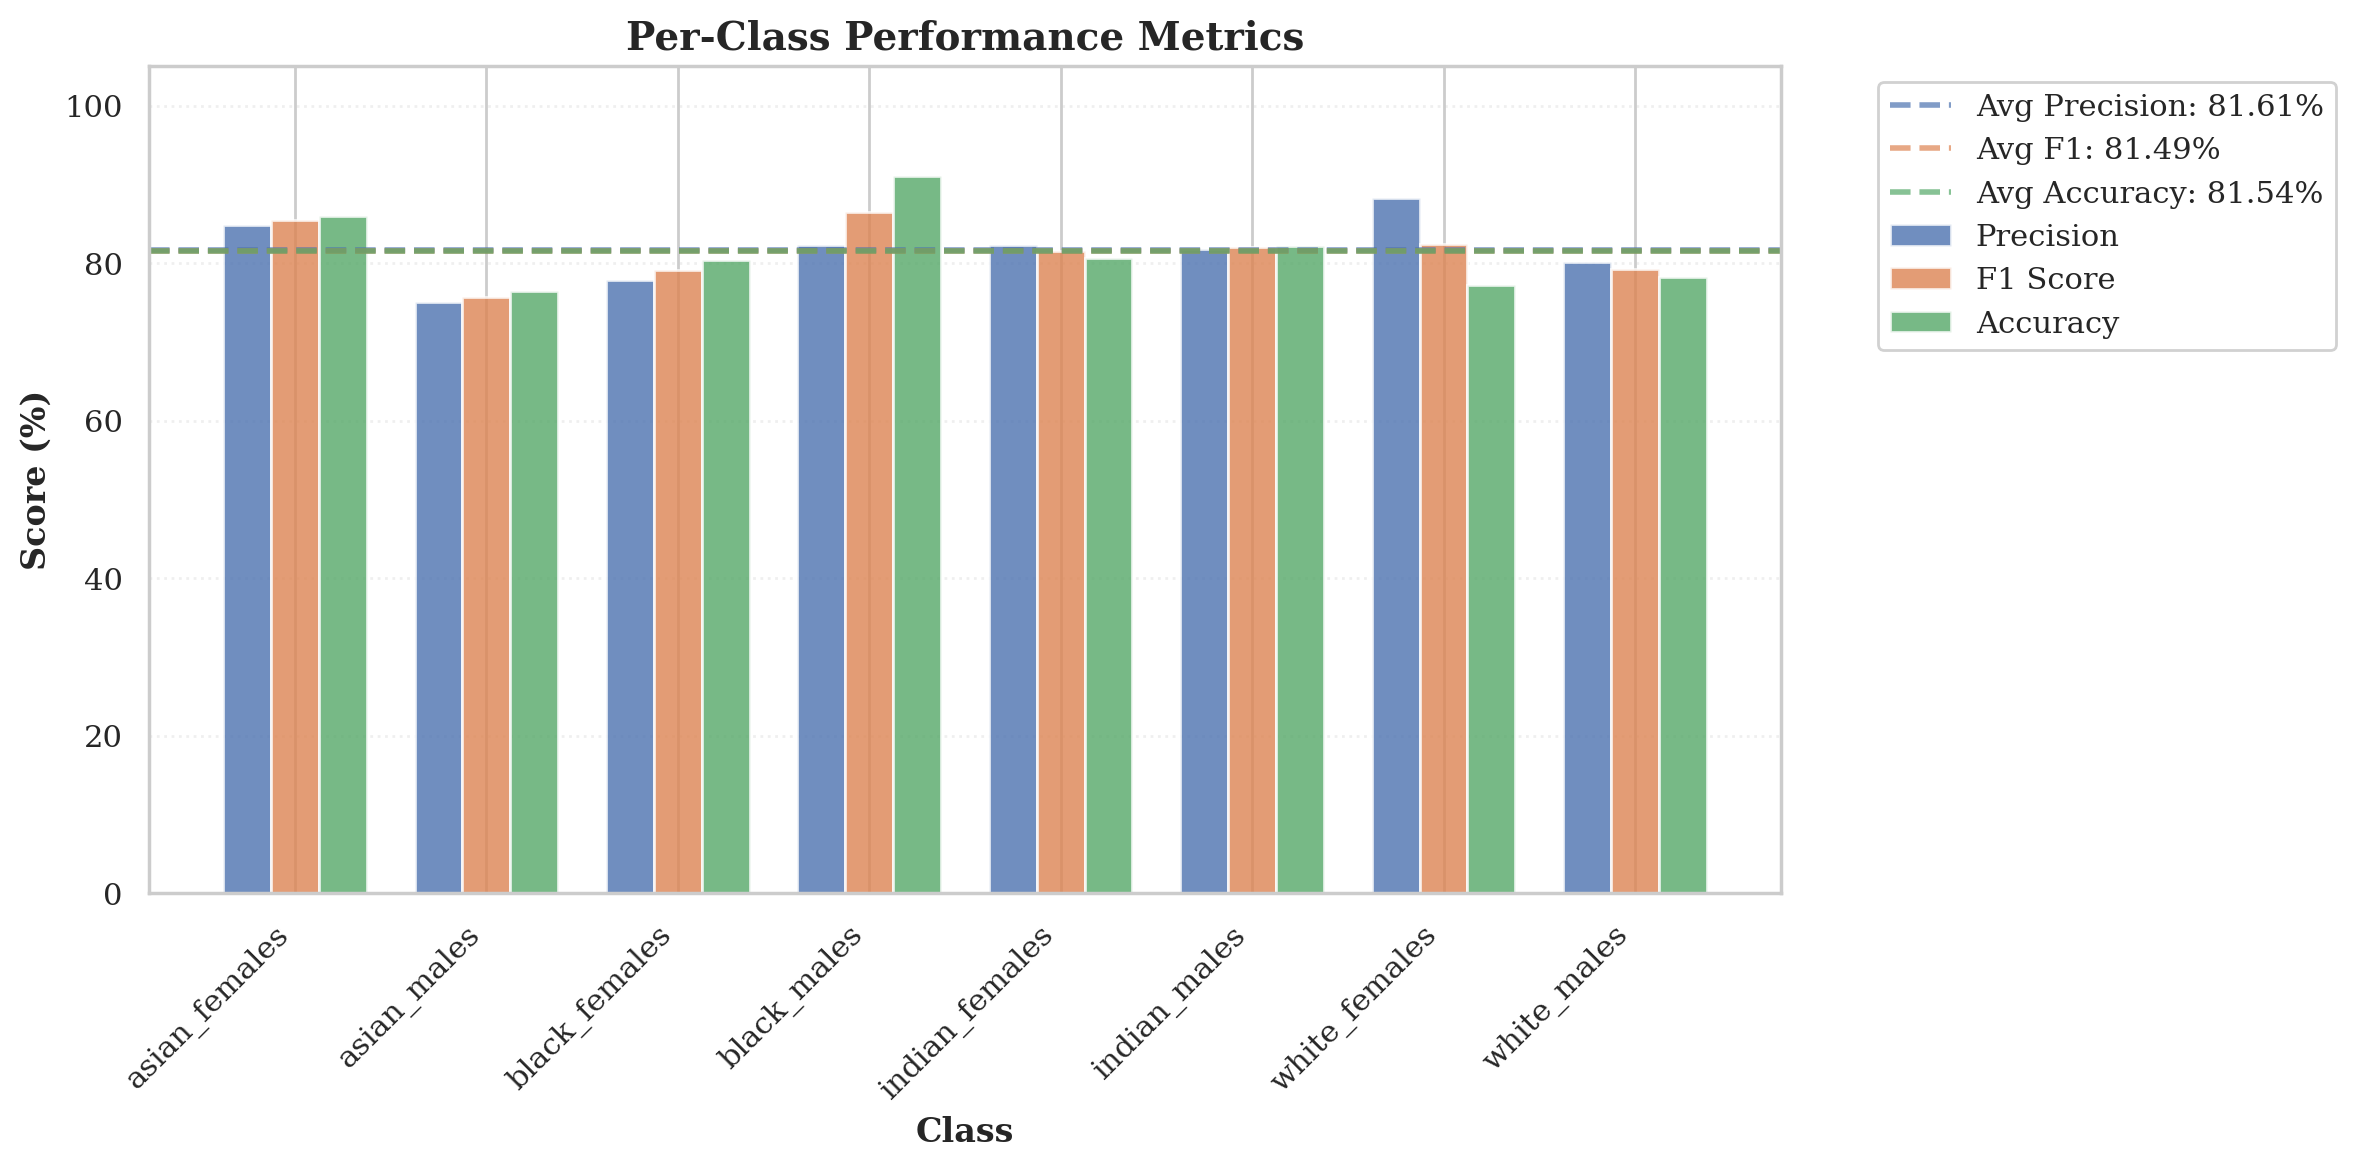

In [5]:
plot_acc_prec_f1_metrics(results, classes)

The plot shows some difference in classes, with black men performing the best in F1 score and accuracy, and asian men performing the worst on all metrics. However, looking at only these regular metrics is not enough to make a thorough assessment on fairness of the model. There are different other metrics that measure this, which are more useful to identify a model's bias. In the `evaluate_fairness` function, we also compute: 

- **Demographic Parity:** The rate at which the model makes positive predictions for each group, regardless of ground truth.
    - `positive_predictions / total_samples` for each group
    -  **ideal case:** all groups have same similar positive prediction rates. 
- Equal Opportunity (TPR): Among individuals who actually belong to the positive class, what percentage does the model correctly identify?
    - ` true_positives / (true_positives + false_negatives)` for each group
    - **ideal case:** all groups should have similar TPR.
- **Individual Fairness Proxy (Embedding Distance):** The average distance between feature representations (embeddings) of samples within each group, measuring how similarly the model internally represents individuals from the same group.
    - `average(||embedding_i - embedding_j||)` for all pairs (i,j) within each group
    - **ideal case:** all groups should have similar average embedding distances, indicating the model recognizes comparable levels of individual variation across groups and doesn't stereotype or homogenize any particular group.

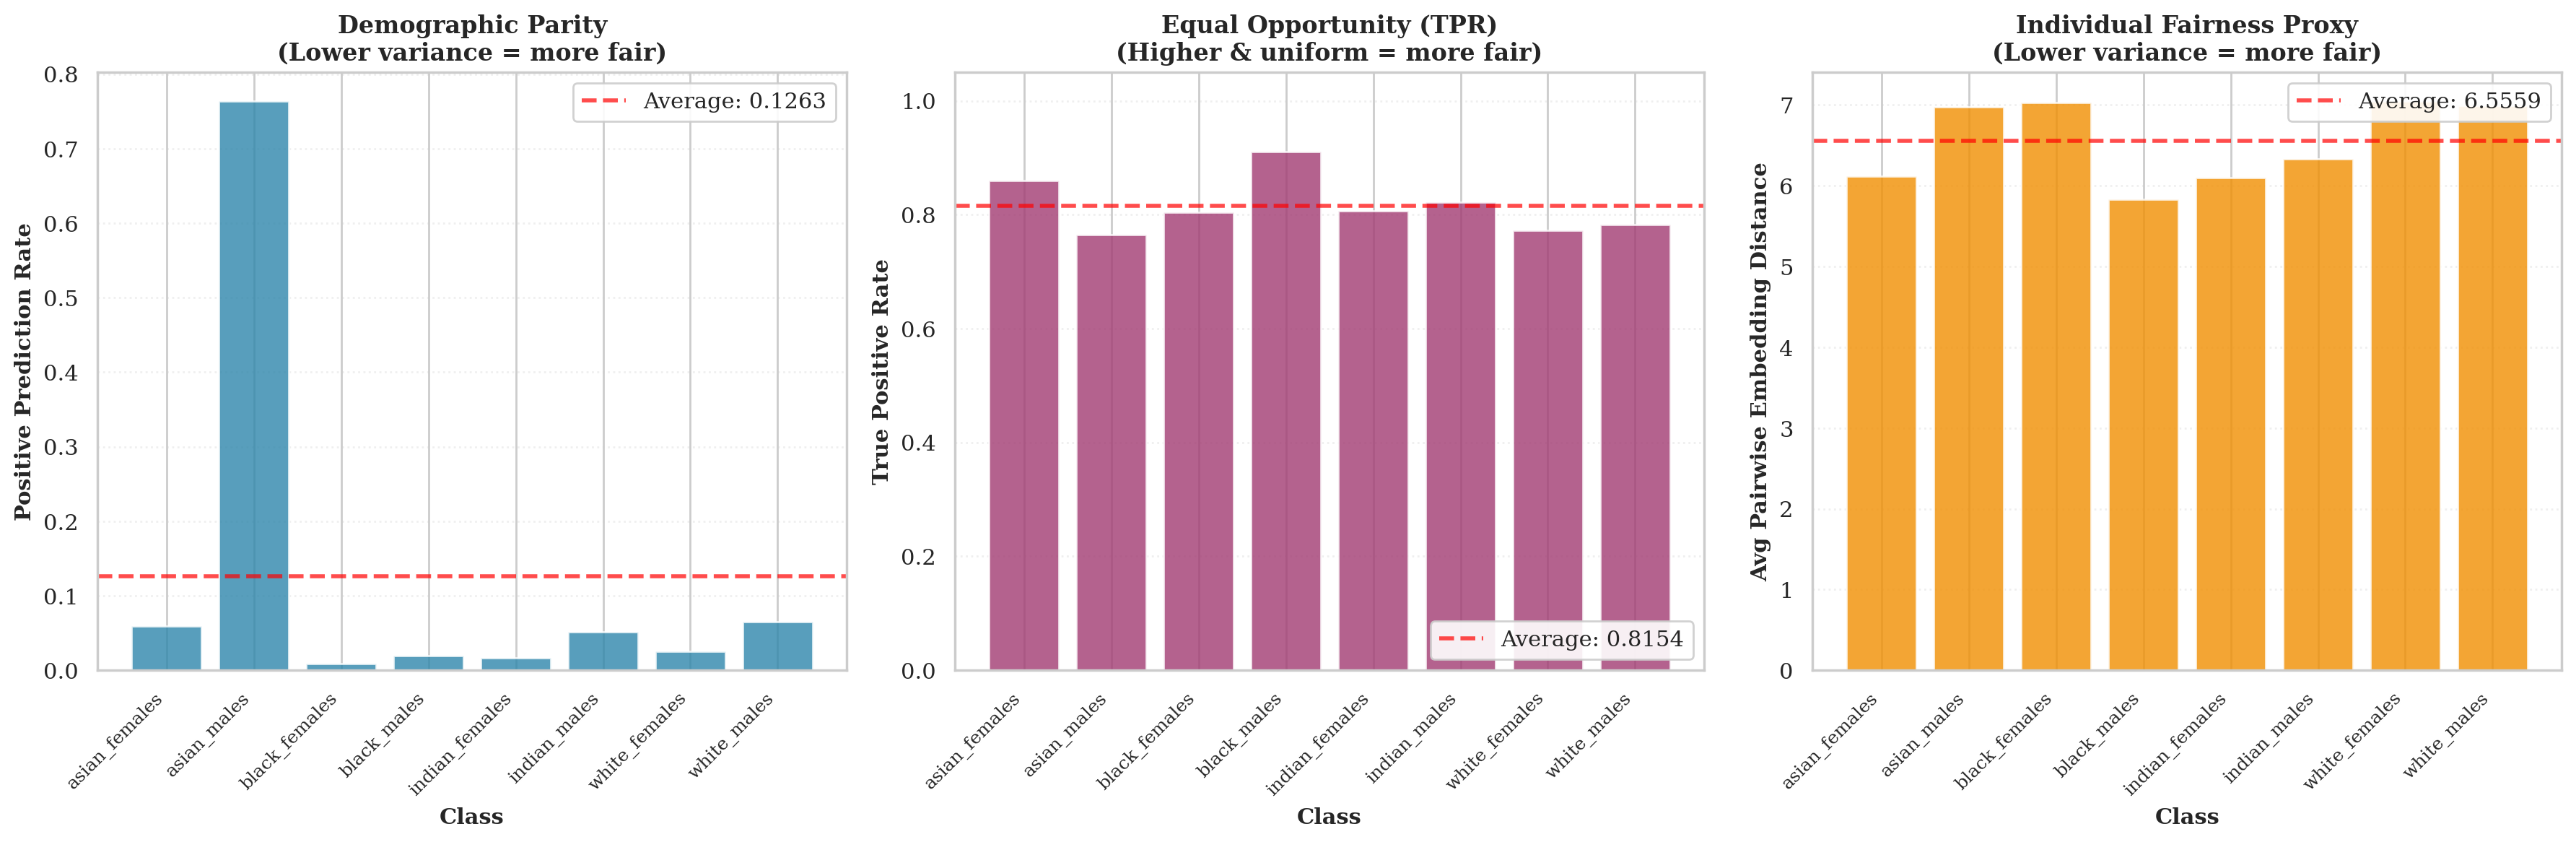


FAIRNESS METRICS SUMMARY

Demographic Parity:
  Mean: 0.1263
  Std Dev: 0.2419
  Range: [0.0084, 0.7642]

Equal Opportunity (TPR):
  Mean: 0.8154
  Std Dev: 0.0461
  Range: [0.7642, 0.9111]

Individual Fairness Proxy:
  Mean: 6.5559
  Std Dev: 0.4772
  Range: [5.8287, 7.0532]



In [6]:
plot_bias_fairness_metrics(results, classes)

### **Overall Performance**
- **Accuracy:** 81.5%  
- **Macro F1:** 81.4%  
- Moderate variation across groups (**std dev ≈ 4.8**).

---

### **Key Bias Findings**

#### **1. Performance Disparities**
- **Highest-performing group:** **Black males** (Accuracy 91.7%, F1 86.3).  
- **Lowest-performing groups:**  
  - **Asian males** (Accuracy 77.0%, F1 76.3)  
  - **White males** (Accuracy 76.9%, F1 79.2)  
  - **White females** (Accuracy 77.6%)  
- **Gap:** ~15 percentage points between best and worst → **significant accuracy disparity**.

---

#### **2. Demographic Parity (DP)**
- Most groups: DP ≈ **0.01–0.08**  
- **Asian males:** **0.77** → **severe violation**, model heavily over-predicts positives for this group.

---

#### **3. Equal Opportunity (TPR)**
- High TPR: **Black males (0.917)**, **Asian females (0.853)**  
- Lower TPR: **White males (0.769)**, **Asian males (0.770)**  
- Indicates **unequal true positive rates** across groups.

---

#### **4. Individual Fairness Proxy**
- Best (lowest score): **Black males (≈5.83)**  
- Worst: **White females / Black females (≈7.05)**  
- Suggests **greater per-individual inconsistency** for some groups.

---

### Bias Patterns

1. Black men are predicted far more accurately than all other groups. This unusually high performance indicates possible overfitting, data differences, or label bias.

2. Asian males have extremely high positive prediction rates (DP), which indicates that the model over-predicts the positive class for this group. 

2. White and asian men have the lowest TPR/accuracy, which indicates that these groups are disadvantaged in terms of correct classification.

4. There are moderate disparities exist across nearly every fairness metric. So the model is not equitable across demographic intersections of race × gender.


# Packages 

Now that we have built the CNN to classify gender and race, we can dive into the models’ explainability. Particularly, the next section allows us to look into into the feature attribution and feature visualization of the libraries Xplique and eXplain-NNs. Different models make different choiches, and we will analyze some of the models’ metrics for bias and fairness, to trace some of the models’ bias to the decisions it makes through its explainability. 

# Xplique

## Feature attribution


In [7]:
tf.config.run_functions_eagerly(True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 1. Initialize TorchWrapper
Xplique requires a wrapper to interface with PyTorch models.
The wrapper handles the translation between numpy arrays and Torch tensors.

In [8]:
wrapped_model = TorchWrapper(model, device)

/Users/admin/miniconda3/envs/deepl_final_project_xai/lib/python3.10/site-packages/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


### 2. Prepare data
Let's fetch a batch of data from the validation loader, convert PyTorch tensors to Numpy arrays for Xplique processing and select a subset of samples (e.g., 16) to ensure computational efficiency

In [9]:
images, targets = next(iter(val_loader))

sample_size = 16
X = images[:sample_size].cpu().detach().numpy().transpose(0, 2, 3, 1)
Y = targets[:sample_size].cpu().detach().numpy()
Y = tf.one_hot(Y, depth=8).numpy().astype("float32")

### 3. Define Attribution Methods
We select a diverse set of explainers compatible with PyTorch
| Method | Description |
|--------|-------------------|
| **Saliency** | Computes the gradient of the output with respect to the input to highlight which input pixels most influence the prediction. |
| **Gradient × Input** | Multiplies raw gradients by the input itself, emphasizing features whose values strongly interact with the gradient signal. |
| **Integrated Gradients** | Averages gradients along a path from a baseline input to the actual input, reducing noise and providing a smoother attribution. |
| **SmoothGrad** | Adds noise to the input and averages multiple saliency maps to reduce gradient noise and sharpen important regions. |
| **SquareGrad** | Similar to SmoothGrad but averages squared gradients, amplifying consistently strong gradient regions. |
| **VarGrad** | Uses the variance (instead of mean) of noisy gradient samples to highlight features with consistently high sensitivity. |
| **Occlusion** | Masks small patches of the input and measures how prediction changes, revealing regions whose removal impacts the model. |
| **RISE** | Generates many random binary masks and estimates pixel importance by correlating model outputs with masked inputs. |
| **Sobol** | Uses Sobol sensitivity analysis to decompose prediction variance into contributions from individual features and interactions. |
| **LIME** | Builds a local, interpretable model around a specific input by perturbing features and observing corresponding prediction changes. |
| **KernelSHAP** | Approximates Shapley values using a weighted linear model, estimating each feature’s contribution to the prediction. |


In [10]:
batch_size = 64
explainers = [
             Saliency(wrapped_model),
             GradientInput(wrapped_model),
             IntegratedGradients(wrapped_model, steps=80, batch_size=batch_size),
             SmoothGrad(wrapped_model, nb_samples=80, batch_size=batch_size),
             SquareGrad(wrapped_model, nb_samples=80, batch_size=batch_size),
             VarGrad(wrapped_model, nb_samples=80, batch_size=batch_size),
             #Occlusion(wrapped_model, patch_size=10, patch_stride=5, batch_size=batch_size),
             #Rise(wrapped_model, nb_samples=4000, batch_size=batch_size),
             SobolAttributionMethod(wrapped_model, batch_size=batch_size),
             Lime(wrapped_model, nb_samples = 4000, batch_size=batch_size),
             KernelShap(wrapped_model, nb_samples = 4000, batch_size=batch_size)
]

In [27]:
# Runs about 2 hours on CPU
explanations_to_test = {}

for explainer in explainers:

  explainer_name = explainer.__class__.__name__
  explanations = explainer(X, Y)

  if len(explanations.shape) > 3:
    explanations = np.mean(explanations, -1)

  # store the explanations to use the metrics
  explanations_to_test[explainer_name] = explanations

  print(f"Method: {explainer_name}")
  plot_attributions(explanations[:5], X[:5], cmap='jet', alpha=0.4,
                    cols=5, clip_percentile=0.5, absolute_value=True)
  plt.show()
  print("\n")

TypeError: 'Saliency' object is not callable

### 5. Metric Evaluation
Now, we define metrics to assess the quality of explanations.
Batch size is set to manage memory usage during metric perturbation steps.
 | Metric | Description |
|--------|-------------|
| **Mu Fidelity** | Checks whether pixels with high importance really affect the model’s score by masking random pixel subsets and measuring correlation.|
| **Deletion** | How fast the model's confidence drops when the most important pixels (per explanation) are removed. |
| **Insertion** | How quickly the model’s confidence rises when important pixels are added back into an empty image. |
| **Stability** | How much explanations change when small noise is added to the input. |


In [12]:
# Metric Calculators
metric_batch_size = 32

fidelity_metric = MuFidelity(
    wrapped_model, X, Y, 
    batch_size=metric_batch_size, 
    nb_samples=100, 
    grid_size=20
)

deletion_metric = Deletion(
    wrapped_model, X, Y, 
    batch_size=metric_batch_size, 
    steps=10,
    activation="softmax" 
)

insertion_metric = Insertion(
    wrapped_model, X, Y, 
    batch_size=metric_batch_size, 
    steps=10,
    activation="softmax"
)

stability_metric = AverageStability(
    wrapped_model, X[:20], Y[:20], 
    batch_size=metric_batch_size, 
    nb_samples=32
)

/Users/admin/miniconda3/envs/deepl_final_project_xai/lib/python3.10/site-packages/xplique/wrappers/pytorch.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403226260/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  torch_inputs = self.torch.Tensor(np_inputs)


In [16]:
# Runs about 7 minutes on CPU
results_array_metrics = []

for explanation_name, explanations in explanations_to_test.items():
    fidelity_score = fidelity_metric(explanations)
    deletion_score = deletion_metric(explanations)
    insertion_score = insertion_metric(explanations)
    
    results_array_metrics.append({
        "Method": explanation_name,
        "Mu Fidelity (higher is better)": fidelity_score,
        "Deletion (lower is better)": deletion_score,
        "Insertion (higher is better)": insertion_score
    })

df_array_metrics = pd.DataFrame(results_array_metrics)

In [14]:
# Stability metric requires explainer object
# Runs about 2 more hours on CPU, because all explainers are being re-run
results_stability = []

for explainer in explainers:
    explainer_name = explainer.__class__.__name__
    stability_score = stability_metric(explainer)
    
    results_stability.append({
        "Method": explainer_name,
        "Stability (lower is better)": stability_score
    })

df_stability = pd.DataFrame(results_stability)

TypeError: 'Saliency' object is not callable

In [17]:
df_final = pd.merge(df_array_metrics, df_stability, on="Method")
display(df_final)

NameError: name 'df_stability' is not defined

In [18]:
display(df_array_metrics)

Empty DataFrame
Columns: []
Index: []

# Explain NNs

Note on Explain-NNs integration: 

Explain-NNs is not an available pip-installable python package and cant directly wrap pytorch models inside jupyter notebook. To cover the explain nns explainability component of our project we implemented gradient based attribution (saliency, integrated gradient) using captum, which provides similar feature attribution insights. 

## 1. Load trained model 
Load fine-tuned ResNet18 classifier and set to evaluation mode. This model predicts one of the demographic classes from the BFW dataset.

In [22]:
# 1. path
model_path = r"./models/face_classifier_resnet18.pth"   # anpassen, falls nötig
# 2. number of classes
num_classes = 8
# 4. load weights
state_dict = torch.load(model_path, map_location="cpu")
model.load_state_dict(state_dict)

# 5. evaluation
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 2. Load and preprocess input images
Each selected image is converted to RGB and transformed into a normalized pytorch tensor using the same preprocessing pipeline as during the training (resize - tensor - normalisation). It ensures all attribution methods operate on valid model inputs.  

In [24]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# select random img path from dataset
img_path = r"./bfw-cropped-aligned/asian_females/n000148/0269_01.jpg"
# load pic
img = Image.open(img_path).convert("RGB")
x = transform(img).unsqueeze(0)  # shape: 1x3x224x224

print("Tensor shape:", x.shape)

Tensor shape: torch.Size([1, 3, 224, 224])


## 3. Feature Attribution using Saliency Maps 

Saliency maps are among the simplest and most fundamental explainability methods for neural networks. They allow us to understand which pixels in the image most strongly influence the model when it makes its decision.  

In our classification model RsNet18, the saliency maps show the gradient of the models decision based on the input pixels. The brighter a pixel is, the stronger its influence on the model. The darker  pixel is, theless significance it has in the model. They measure local explainability, to identify what is important for the indivial image.

Using Captum's Saliency method we compute the gradient of model output with respect to input pixels. For 10 selected images  from different groups we calculate saliency maps and visualize the heatmaps.

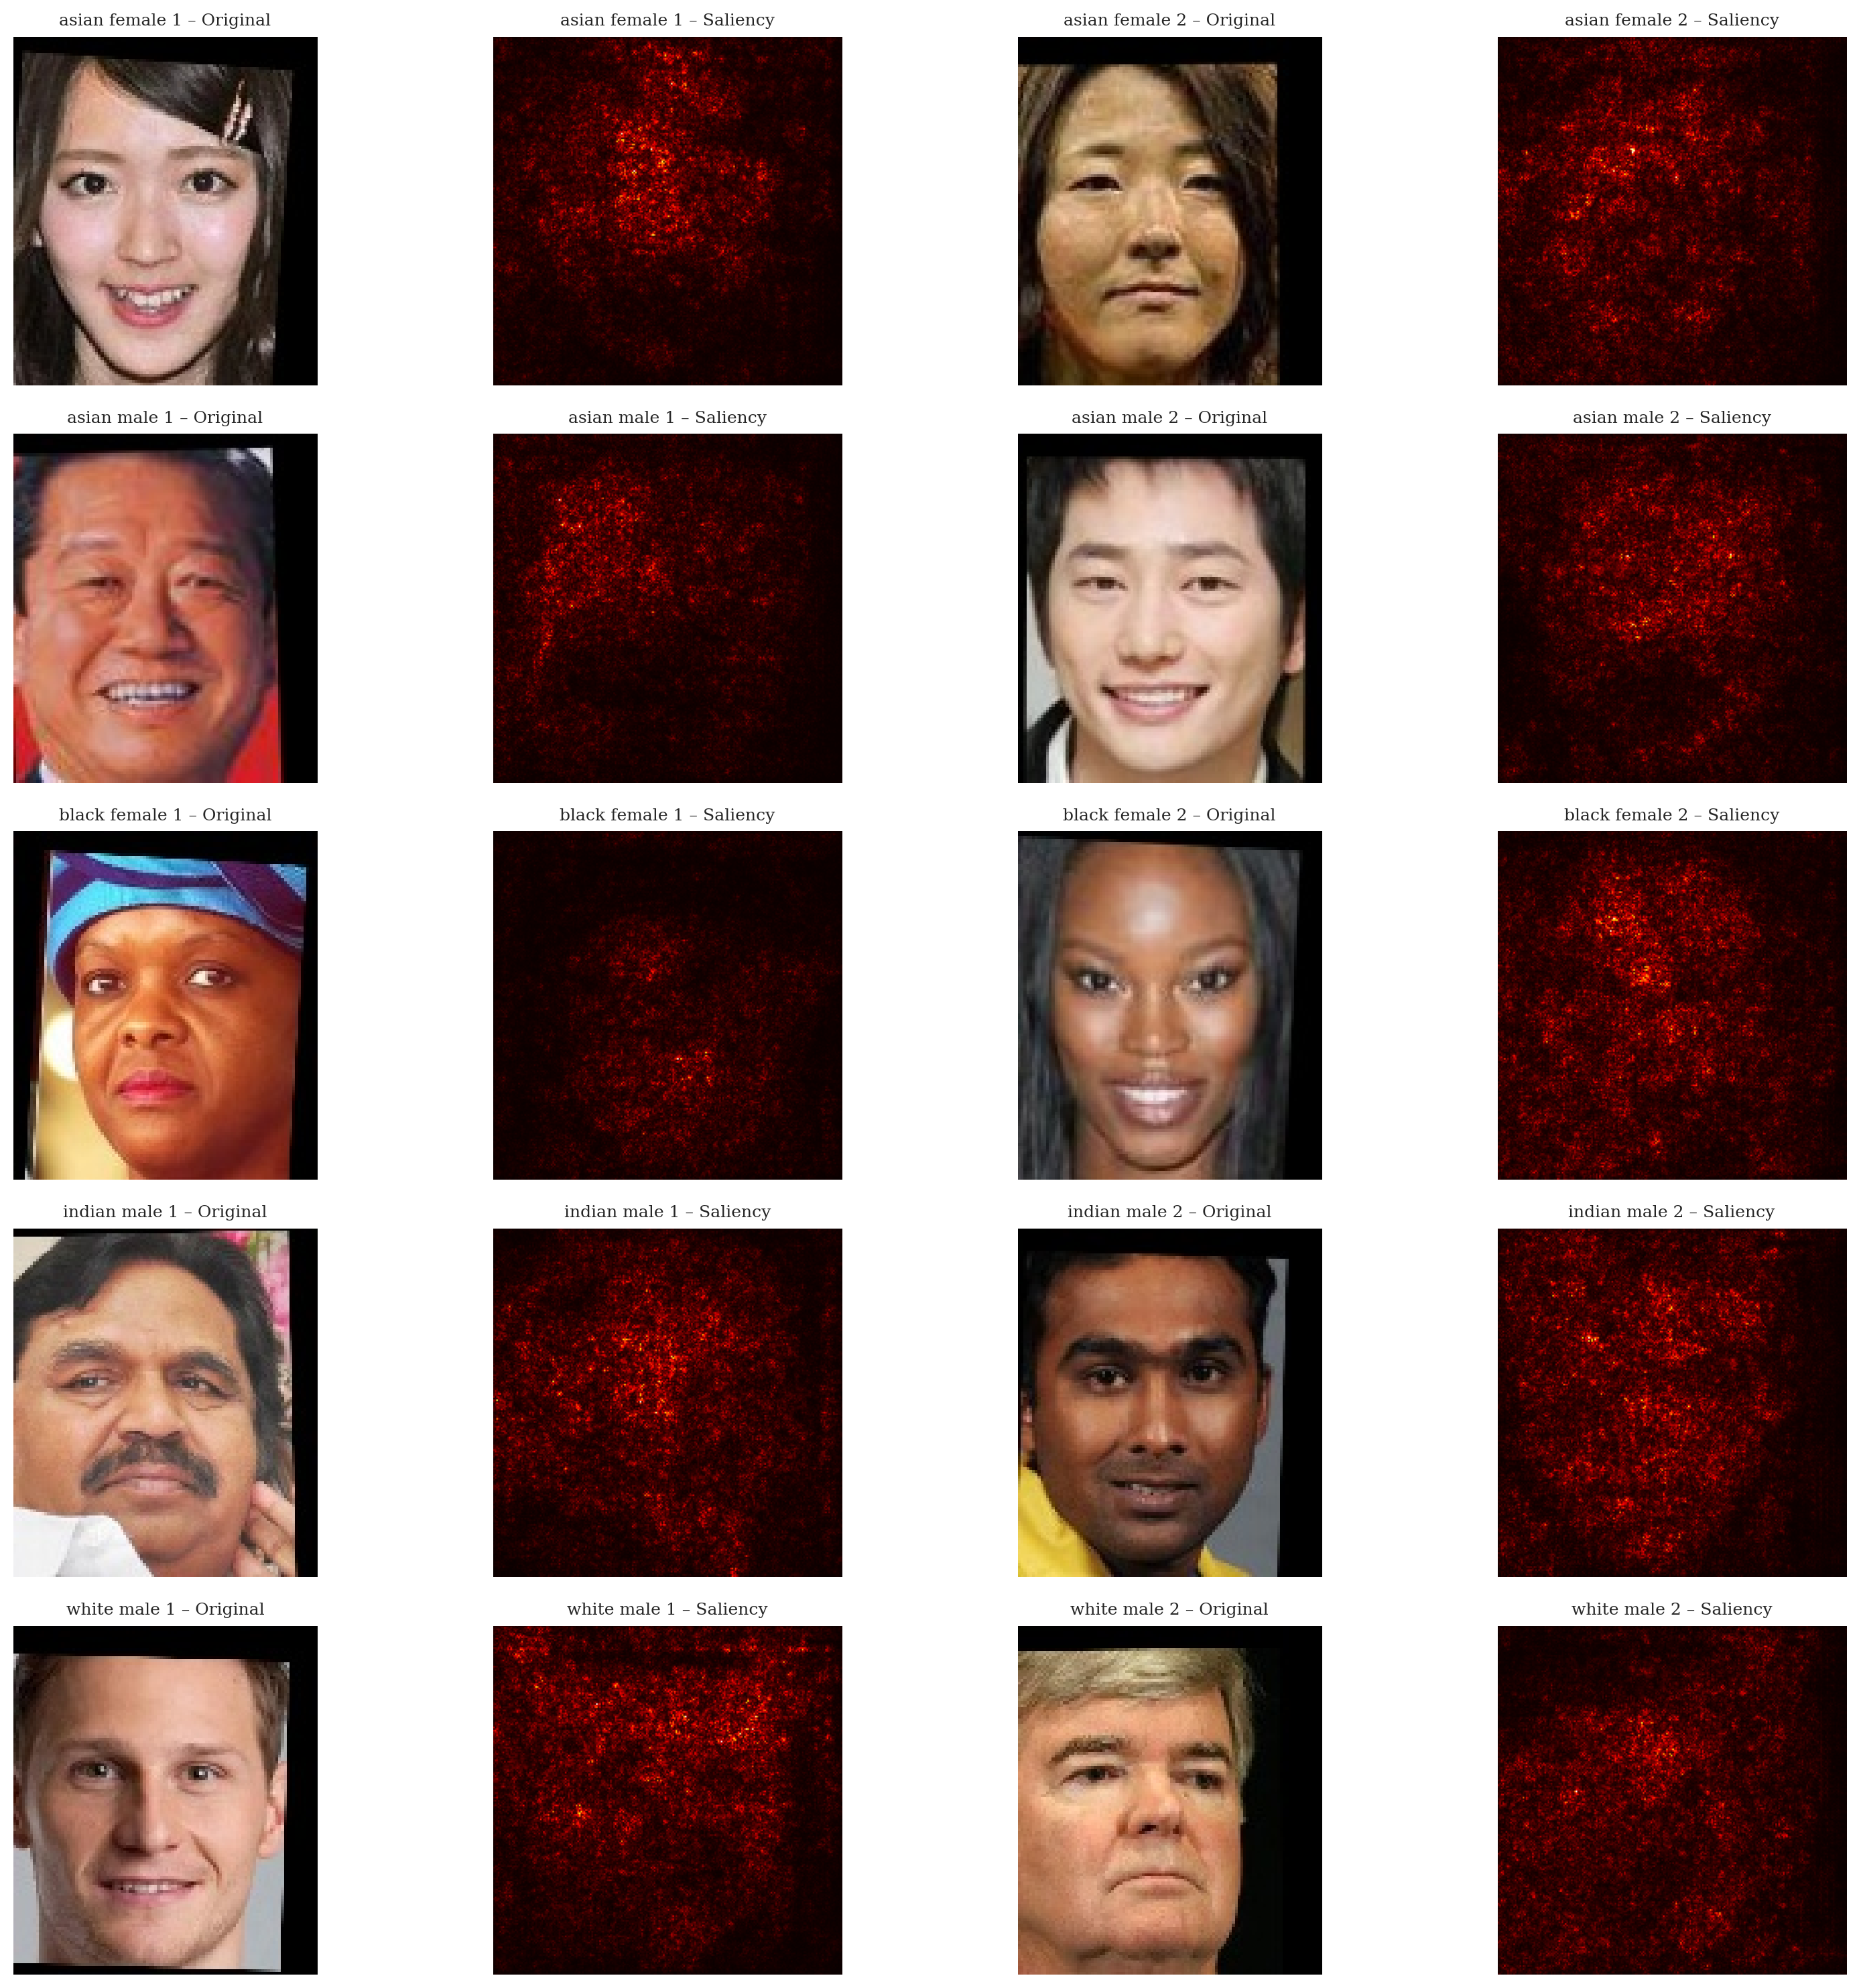

In [25]:
#group pic-pairs  
groups = [
    ("asian female",
     # correct the paths to relative paths 
     
        r"./bfw-cropped-aligned/asian_females/n000148/0269_01.jpg",
        r"./bfw-cropped-aligned/asian_females/n000838/0500_01.jpg"),

    ("asian male",
        r"./bfw-cropped-aligned/asian_males/n003533/0115_01.jpg",
        r"./bfw-cropped-aligned/asian_males/n004809/0221_01.jpg"),

    ("black female",
        r"./bfw-cropped-aligned/black_females/n003183/0662_02.jpg",
        r"./bfw-cropped-aligned/black_females/n002638/0160_01.jpg"),

    ("indian male",
        r"./bfw-cropped-aligned/indian_males/n001998/0063_01.jpg",
        r"./bfw-cropped-aligned/indian_males/n005429/0006_01.jpg"),
    ("white male",
        r"./bfw-cropped-aligned/white_males/n000957/0474_01.jpg",
        r"./bfw-cropped-aligned/white_males/n005685/0073_01.jpg")
]

model.eval()
sal = Saliency(model)

# preparing saliency and pics
rows = []  # per group: [(img1, sal1, label), (img2, sal2, label)]

for group_label, img1_path, img2_path in groups:
    row = []
    for img_path in [img1_path, img2_path]:
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0)

        with torch.no_grad():
            logits = model(x)
        pred_class = logits.argmax(1).item()

        attr = sal.attribute(x, target=pred_class)
        attr = attr[0].detach().cpu()
        attr = attr.abs().max(dim=0)[0].numpy()
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

        row.append((img, attr, group_label))
    rows.append(row)

# plot:per row pic1, sal1, pic2, sal2
num_groups = len(rows)
plt.figure(figsize=(16, 3*num_groups))

plot_idx = 1
for (img1, sal1, label1), (img2, sal2, label2) in rows:
    # pic 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img1)
    plt.title(f"{label1} 1 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # saliency 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(sal1, cmap="hot")
    plt.title(f"{label1} 1 – Saliency", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # pic 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img2)
    plt.title(f"{label2} 2 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # saliency 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(sal2, cmap="hot")
    plt.title(f"{label2} 2 – Saliency", fontsize=9)
    plt.axis("off")
    plot_idx += 1

plt.tight_layout()
plt.show()

## Automated Integrated Gradients pipeline 

Batch script was created to iterate over all chosen images, compute integrated gradients & plt the original image alongside its ig heatmap + save the results to figures/integrated_gradients/

In [26]:
# save direction
save_dir_ig = r"./figures/integrated_gradients"
os.makedirs(save_dir_ig, exist_ok=True)

model.eval()
ig = IntegratedGradients(model)

# save results (original + IG
rows = []  # every row = [(img1, ig1, label), (img2, ig2, label)]

for group_label, img1_path, img2_path in groups:
    row = []

    for img_path in [img1_path, img2_path]:

        # 1) load pic
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0)

        # 2) prediction
        with torch.no_grad():
            logits = model(x)
        pred_class = logits.argmax(1).item()

        # 3) Integrated Gradients
        baseline = torch.zeros_like(x)
        attr_ig = ig.attribute(x, baselines=baseline, target=pred_class)

        # 4) 2D-Heatmap
        attr = attr_ig[0].detach().cpu()          
        attr = attr.abs().max(dim=0)[0].numpy()   
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

        row.append((img, attr, group_label))

    rows.append(row)

# 2. plot: original 1 → IG 1 → original 2 → IG 2  per row
num_groups = len(rows)
plt.figure(figsize=(16, 3 * num_groups))

plot_idx = 1
for (img1, ig1, label1), (img2, ig2, label2) in rows:

    # original 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img1)
    plt.title(f"{label1} 1 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # IG 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(ig1, cmap="hot")
    plt.title(f"{label1} 1 – IG", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # priginal 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img2)
    plt.title(f"{label2} 2 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # IG 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(ig2, cmap="hot")
    plt.title(f"{label2} 2 – IG", fontsize=9)
    plt.axis("off")
    plot_idx += 1

plt.tight_layout()
plt.show()

AttributeError: 'IntegratedGradients' object has no attribute 'attribute'

### What do we see?
The saliency maps provide an inital indication of which regions the model focuses on, wether it concentrates on facial features or whether it exhibits different patterns across different groups. This is important in the context of bias and fairness, because we want to know if the model shows less clear or chaoti activations in certain groups.

The model focuses on central facial regions, skin texture, contours and shadings/highlights. The saliency maps show that the model is not dependent on indiviual dominant facial regions but utilizes a multitude of subtle, texture based signals across the entire face. 

We see, that these maps have  limitations as they exhibit chaotic, "difficult to interpret"-activations and are sensitive to small pixel changes. Therefore, the results show few clear pattrns and are not very informative.

# Integrated Gradients 

Integrated Gradients (IG) is an evolution of simple saliency maps and was developed to address their key weaknesses. But saliency maps are based on a single gradient step, they are highly sensitive to pixel noise, model instabilities, small exposure variations and random gradient noise.

According to the official Captum documentation, sliency maps rely exclusively on local gradients and are therefore highly sensitive to noise and small input perturbations, while IG, by integrating graidents across a path produce more reliable and smoother attributions (Source: Captum – Integrated Gradients & Saliency Documentation, https://captum.ai/).

## Automated Integrated Gradients pipeline 

To analyze multiple samples, we implemented an automated pipeline that processes all selected images in a single batch. For each image the script

1. loads and preprocesses the inpus using the same transformation pipeline as the trained model
2. computes the model prediction to identify the target clas for attribution 
3. generates integrated gradients by integrating gradients along the path from a baseline image (black image) to the actual input
4. converts the resulting attribution tensor into a 2d heatmap, normalised for visualization
5. plots the original image next to its integrated gradients map, allowing direct qualitative comparison
6. automatically saves all generated visualizations into the folder fo documentation and downstream analysis. 

This automated routine ensures consistent processing, reproducibility and visualization across all demopraphic groups included in the study. 

In [ ]:

#1. save direction
save_dir_ig = r"./figures/integrated_gradients"

os.makedirs(save_dir_ig, exist_ok=True)

model.eval()
ig = IntegratedGradients(model)

# save results (Original & IG)
rows = []  #every row = [(img1, ig1, label), (img2, ig2, label)]

for group_label, img1_path, img2_path in groups:
    row = []

    for img_path in [img1_path, img2_path]:

        # 1) load pic
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0)

        # 2) prediction
        with torch.no_grad():
            logits = model(x)
        pred_class = logits.argmax(1).item()

        # 3) Integrated Gradients
        baseline = torch.zeros_like(x)
        attr_ig = ig.attribute(x, baselines=baseline, target=pred_class)

        # 4) 2D-Heatmap
        attr = attr_ig[0].detach().cpu()          
        attr = attr.abs().max(dim=0)[0].numpy()   
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

        row.append((img, attr, group_label))

    rows.append(row)

# 2. Plot: Original 1 → IG 1 → Original 2 → IG 2 per row
num_groups = len(rows)
plt.figure(figsize=(16, 3 * num_groups))

plot_idx = 1
for (img1, ig1, label1), (img2, ig2, label2) in rows:

    # Original 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img1)
    plt.title(f"{label1} 1 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # IG 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(ig1, cmap="hot")
    plt.title(f"{label1} 1 – IG", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # Original 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img2)
    plt.title(f"{label2} 2 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # IG 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(ig2, cmap="hot")
    plt.title(f"{label2} 2 – IG", fontsize=9)
    plt.axis("off")
    plot_idx += 1

plt.tight_layout()
plt.show()

## What do we see?

The IG heatmaps are signifiantly clearer and more structured than the saliency maps. We observe brighter, more defined activation areas, less noise ad better contours in the central face area. The model thus uses stable, recurring features for its decision making. 

While saliency maps appear strongly texture-driven, the IG maps show activation around the eye regions and light emphasis on the outlines of the nose and mouth. 